# Random Forest - Classification

## The Data

We will be using the same dataset through our discussions on classification with tree-methods (Decision Tree,Random Forests, and Gradient Boosted Trees) in order to compare performance metrics across these related models.

We will work with the "Palmer Penguins" dataset, as it is simple enough to help us fully understand how changing hyperparameters can change classification results.




Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

Summary:
The data folder contains two CSV files. For intro courses/examples, you probably want to use the first one (penguins_size.csv).

* penguins_size.csv: Simplified data from original penguin data sets. Contains variables:

    * species: penguin species (Chinstrap, Adélie, or Gentoo)
    * culmen_length_mm: culmen length (mm)
    * culmen_depth_mm: culmen depth (mm)
    * flipper_length_mm: flipper length (mm)
    * body_mass_g: body mass (g)
    * island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    * sex: penguin sex

* (Not used) penguins_lter.csv: Original combined data for 3 penguin species  

Note: The culmen is "the upper ridge of a bird's beak" 

**Our goal is to create a model that can help predict a species of a penguin based on physical attributes, then we can use that model to help researchers classify penguins in the field, instead of needing an experienced biologist**

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("penguins_size.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
df.dropna(inplace=True)
df.head()

# Missing valueları drop ediyoruz.

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


## Exploratory Data Analysis and Visualization

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,334.0,43.994311,5.460521,32.1,39.5,44.5,48.575,59.6
culmen_depth_mm,334.0,17.160479,1.967909,13.1,15.6,17.3,18.700,21.5
flipper_length_mm,334.0,201.014970,14.022175,172.0,190.0,197.0,213.000,231.0
body_mass_g,334.0,4209.056886,804.836129,2700.0,3550.0,4050.0,4793.750,6300.0


In [6]:
for feature in df.columns:
    if df[feature].dtype=="object":
        print(df[feature].unique())

# object featurların unique kategorik gözlemlerini listeliyoruz. Sex'te "." olarak yanlış bir kategorik veri var. Bundan
# kurtulmamız gerekiyor.

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['MALE' 'FEMALE' '.']


In [7]:
df[df["sex"]== "."]

# sex featurandaki yanlış kategorik veriyi tespit ediyoruz.

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [8]:
df.drop(index=336, inplace=True)

# sex featurandaki yanlış kategorik veriyi drop ediyoruz.

In [9]:
df.sex.unique()

array(['MALE', 'FEMALE'], dtype=object)

In [10]:
df2 = df.copy()

## Visualization

In [11]:
df["species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

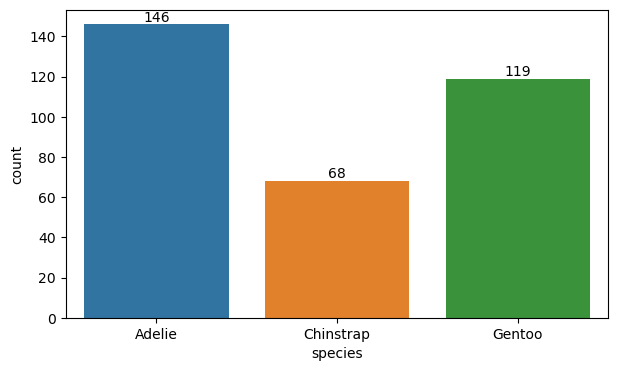

In [12]:
ax = sns.countplot(x="species", data = df)
ax.bar_label(ax.containers[0]);

# Datamda bir inbalanced durumu söz konusu ancak dataya bir inbalanced muamelesinde bulunup bulunmayacağımıza scorları gördükten
# sonra karar vereceğiz.

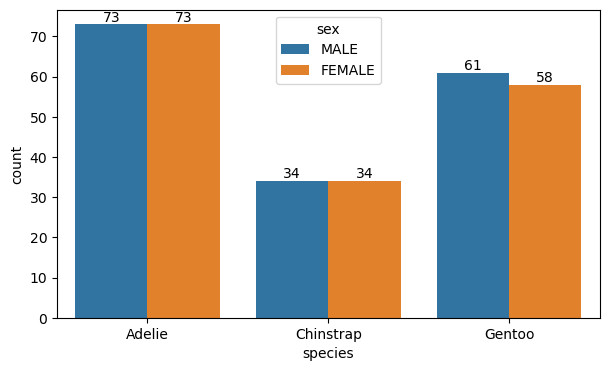

In [13]:
ax = sns.countplot(x="species", data = df, hue = "sex")
for p in ax.containers:
    ax.bar_label(p)

# cinsiyetlere göre dağılımı

<Figure size 400x600 with 0 Axes>

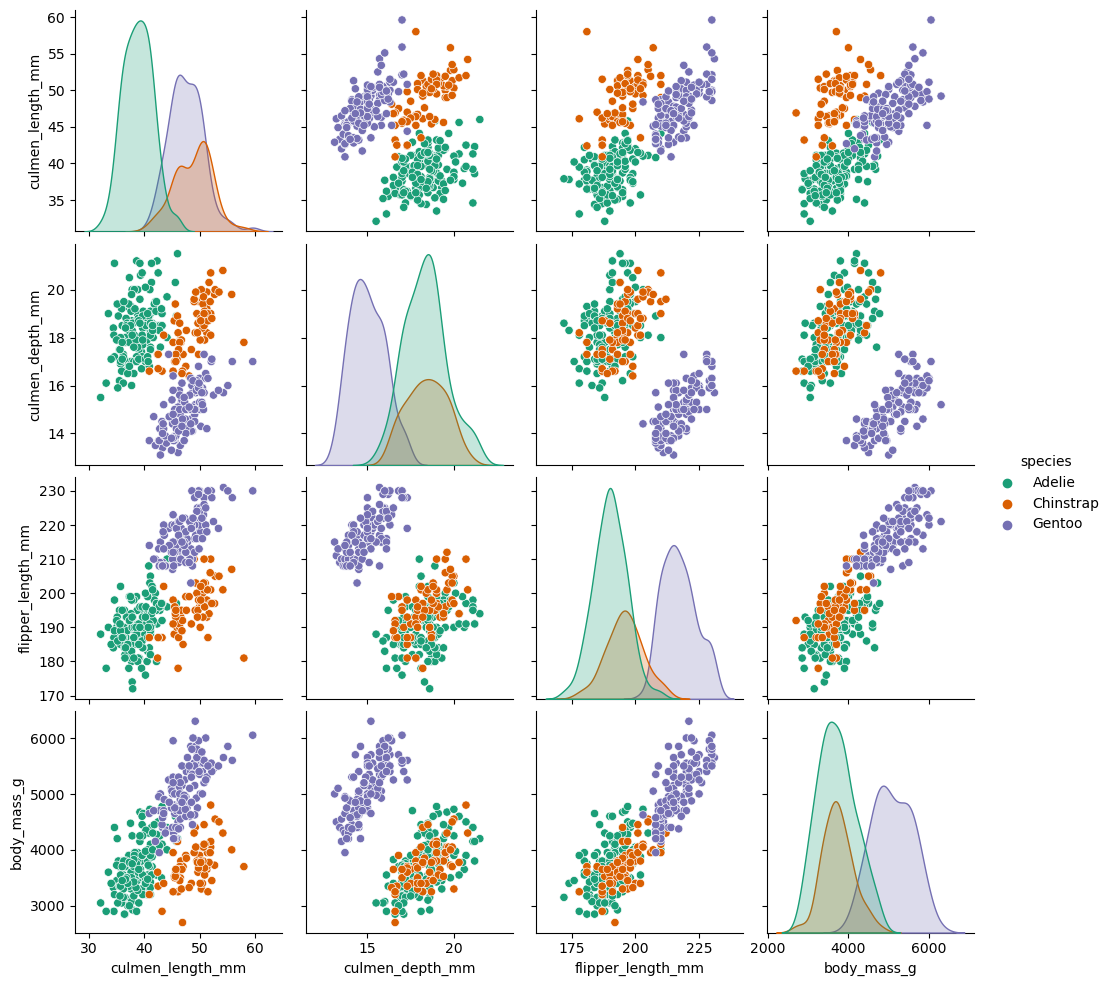

In [14]:
plt.figure(figsize=(4,6))
sns.pairplot(df,hue='species',palette='Dark2')

# Burada herbir featuran ne kadar ayırt edici özellikte olduğunu görmekle birlikte labelların hangi featurlar özelinde
# nasıl ayrıştıklarını da görebiliyoruz.

In [15]:
df.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

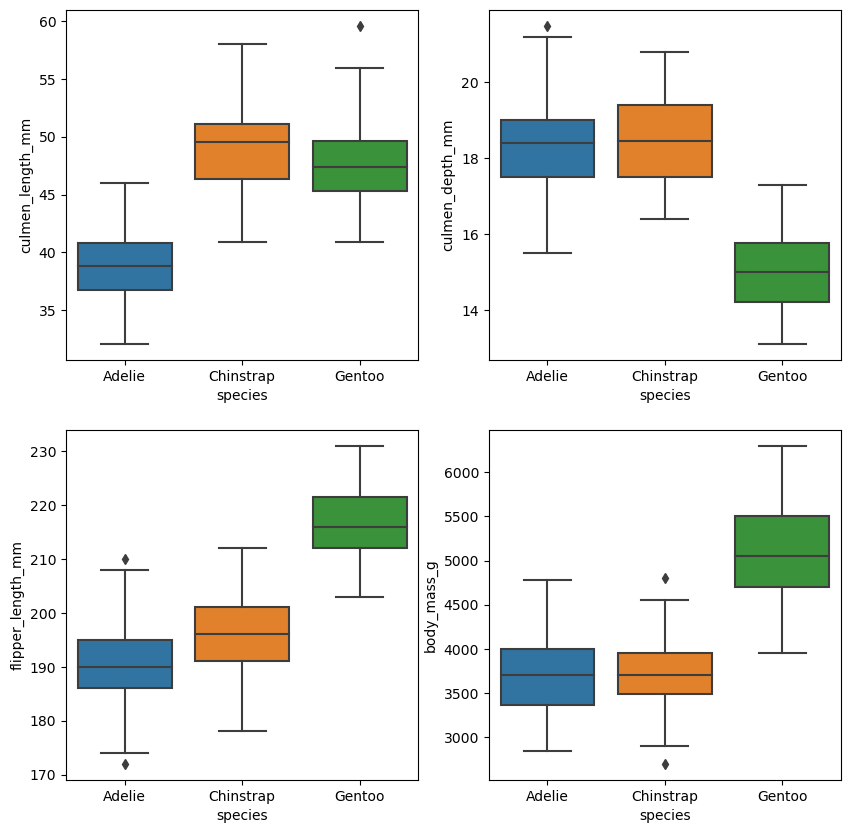

In [16]:
index = 0
plt.figure(figsize=(10,10))
for feature in df.select_dtypes("number"):
    if feature != "species":
        index += 1
        plt.subplot(2,2,index)
        sns.boxplot(x='species',y=feature,data=df)
        
# pair plotdan aldığımız insigtları buradan da alabiliyoruz.

## Correlation beetwen numeric features

In [17]:
df.select_dtypes("number").corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.228626,0.653096,0.589451
culmen_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


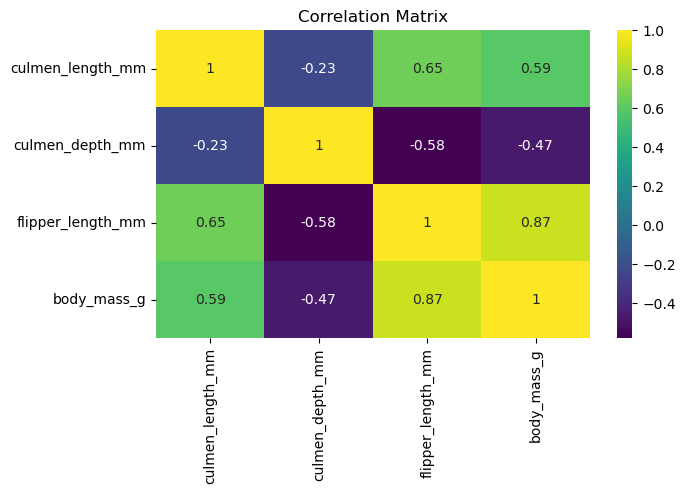

In [18]:
sns.heatmap(df.select_dtypes("number").corr(),annot=True, cmap='viridis')
plt.title("Correlation Matrix")

plt.show()

## OrdinalEncoder

https://bookdown.org/max/FES/categorical-trees.html

https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

## Modeling with Pipeline

## Train | Test Split

In [19]:
X = df.drop(columns="species")
y = df['species']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [21]:
X_train.head(2)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
285,Biscoe,49.8,16.8,230.0,5700.0,MALE
183,Dream,54.2,20.8,201.0,4300.0,MALE


In [22]:
X_test.head(2)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
89,Dream,38.9,18.8,190.0,3600.0,FEMALE
143,Dream,40.7,17.0,190.0,3725.0,MALE


In [23]:
cat = X_train.select_dtypes("object").columns
cat

# Dönüşümleri train datasındaki unique kategorik verilere göre yapacağımızdan öncelikle train datasındaki kategorik featurları
# tespit etmemiz gerektiğini unutmuyoruz.

Index(['island', 'sex'], dtype='object')

In [24]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

# İşlemlerimizi otomatize etmek için one hot encoderda olduğu gibi make_column_transformer ve pipeline kullanacağız.
# Ordinal encoder algortiması içerisinde handle_unknown parametresi defaul olarak "error"dür. Eğer bunu errorde bırakırsak
# train datasında olmayıp test datasında olan bir kategorik veri ile karşılaşıldığında algoritma hata döndürür. Ancak
# handle_unknown='use_encoded_value' ve unknown_value=-1 olarak ayarlanırsa train datasında olmayıp test datasında olan bir 
# kategorik veriye -1 değeri atanır. unknown_value=-1 olarak atama sebebimiz, diğer kategorik verilere verilecek aynı numaranın
# verilmeyeceğinden emin olmaktır.

# make_column_transformer((ord_enc, cat), remainder='passthrough') fonksiyonu cat değişkenine tanımladığımız kategorik
# featurları yukarıda bahsettiğimiz şekilde önce numeric verilere dönüştürecek, remainder="passthrough" parametresi ile
# numeric featurara hiçbir işlem yapmayacak olduğu gibi bırakacak.

# make_column_transformer fonksiyonu datanın yapısını değiştiriyor. Categorik feturelar df içerinde ilk featurlar olacak 
# şekilde numeric featurlar ise onları takip edecek şekilde yeniden sıralanır.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

# fit işlemi ile train datasının önce kategorik featurları tespit edilip bu featurlar içerisindeki unique kategorik veriler 
# numeric verilere dönüştürülüyor ve ilgili modele gönderilerek eğitim yapılıyor.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('RF_model', RandomForestClassifier(random_state=101))])

## Model Performance on Classification Tasks

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# predict işlemi test datasını train datasındaki unique kategorik verilere göre transforma tabi tutarak numeric verilere 
# dönüştürüyor.

# pipeline içerisinde make_column_transform olduğundan df yapısı train datasında olduğu gibi değiştiriliyor ve predict edilmek 
# üzere ilgili modele gönderiliyor

### Random Forest

In [27]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [28]:
help(RandomForestClassifier)

# DT'den farkları;
# 1. criterion hyper parametresinde gini ve entropy'e ilave olarak logistik regressionda kullanılan log_loss functionı dahil 
# edilmiştir. Defaultu gini'dir.
# 2. max_features defaultu "sqrt"dir. datamızdaki toplam features sayısının karekökünü alır ve çıkan sonucu integer sayıya
# dönüştürür.
# 3. Random forest algoritmalarında splitter hyper parametresi bulunmaz. Dallanmalar her zaman best (en iyi) featura göre
# yapılır. Rasgele seçilmez
# 4. bootsrap hyper_pamatresi ilave edilmiştir. Defaultu True'dır. Her agaç için train datasındaki gözlemlerden rastgele 
# boostrap yöntemi ile yaklaşık olarak 2/3'ünü kullanır.
# 5. oob_score hayper parametresi ile her agaç için ayrılan 1/3 gözlem ile her agacın performansı ölçülüyor hem de feature 
# importance tespit ediliyor. oob_scorelarını görmek isterseniz bu hyper parametreyi True olarak ayarlamamız gerekiyor.
# 6. class_weight hyper parametresi olarak hem "balanced" hem de "balanced_subsample" mevcuttur. DT'de "balanced_subsample"
# yoktur. "balanced" ile datadaki toplam class sayısına göre ağırlıklandırma yaparken "balanced_subsaple" ile her agaçtaki
# classların sayısına göre ağırlıklandırma yapar.
# 7. max_samples hyper parametresi ile çok büyük dataların çalışma maaliyetini azaltmak için seçtiğimiz oranlarda
# (tavsiye edilen 0.5, 0.8 oranlarında) gözlemlerle eğitimi yapar.

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [29]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

# default değerlerle scorları DT'e göre çok daha iyi çıktı

Test_Set
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


Train_Set
[[117   0   0]
 [  0  54   0]
 [  0   0  95]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       117
   Chinstrap       1.00      1.00      1.00        54
      Gentoo       1.00      1.00      1.00        95

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



In [30]:
operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"], 
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# overfiting yok.

test_accuracy            0.992593
train_accuracy           1.000000
test_precision_micro     0.992593
train_precision_micro    1.000000
test_recall_micro        0.992593
train_recall_micro       1.000000
test_f1_micro            0.992593
train_f1_micro           1.000000
dtype: float64

## Evaluating ROC Curves and AUC

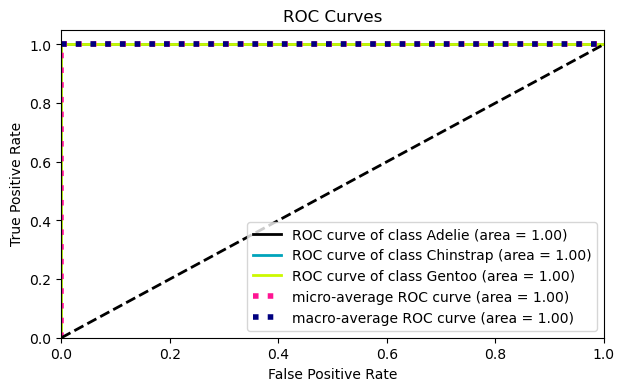

In [31]:
from scikitplot.metrics import plot_roc, precision_recall_curve

operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=101))]

model = Pipeline(steps=operations)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
    
plot_roc(y_test, y_pred_proba)
plt.show();

# model genel performansı çok yüksek doğal olarakta classları birbirlerinden ayırmakta çok başarılı.

### RF Model Feature Importance

In [32]:
pipe_model["RF_model"].feature_importances_ # rf_model.feature_importances_

# pipeline kullandığımızdan pipe_model["DT_model"] ile pipeline içerisinden önce ML modelimizi çekip sonra feature_importance_
# kodu ile toplamları 1 olacak şekilde tüm featurlara %'sel olarak oranlar tanımlanıyor. En yüksek orana sahip feature
# en önemli feature olurken en düşük orana sahip feature ise en önemsiz feature oluyor.


# pipe_model içerisinde kullanılan make_column_transformer fonksiyonu df'deki featurların sıralamasını değiştirdiğinden dolayı
# aşağıda ilk 2 oran categorik featurlara aitken sonraki oranlar numeric featurlara aittir.

# Eğer pipeline içerisinde make_column_transformer kullanılmamış olsaydı df'in feature sıralaması değişmeyecekti. Sıralamanın 
# sadece make_column_transformer fonksiyonu kullanıldığında değiştiğini UNUTMAYALIM.

# feature importance modelden en iyi skorları aldıktan sonra yapılır. Bu data özelinde RF modelinin default hyper 
# parametreleriyle çok yüksek skorlar alabildiğimden gridsearch yapmadan feature importance yaptık. Ancak, gridsearch sonrası
# bulduğumuz en iyi hyper_paramtreler üzerinden feature importance yapmamız gerektiğini unutmuyoruz.

array([0.1090312 , 0.01036703, 0.35052176, 0.15568431, 0.25091596,
       0.12347973])

In [33]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

# pipe_model'den aldığımız yeni feature sıralaması aşağıda olduğu gibidir. Fonksiyon ordinalencoder dönüşümü yaptığı kategoric 
# faturların başına ordinalencoder__ ön ekini ilave ederken numaric featurların başına remainder__ ön ekini atamış. Ama 
# featurelara ait feature importance oranlarını tanımlarken feature isimlerinin daha kolay anlaşılabilir olması maksadıyla 
# aşağıda bu ön eklerden kurtulacağız.

array(['ordinalencoder__island', 'ordinalencoder__sex',
       'remainder__culmen_length_mm', 'remainder__culmen_depth_mm',
       'remainder__flipper_length_mm', 'remainder__body_mass_g'],
      dtype=object)

In [34]:
new_features = [i.replace("ordinalencoder__","").replace("remainder__", "") for i in features]
new_features

['island',
 'sex',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g']

In [35]:
rf_feature_imp = pd.DataFrame(data = pipe_model["RF_model"].feature_importances_, index = new_features, #index=X.columns
                              columns = ["Feature Importance"])

rf_feature_imp = rf_feature_imp.sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
culmen_length_mm,0.350522
flipper_length_mm,0.250916
culmen_depth_mm,0.155684
body_mass_g,0.123480
island,0.109031
sex,0.010367


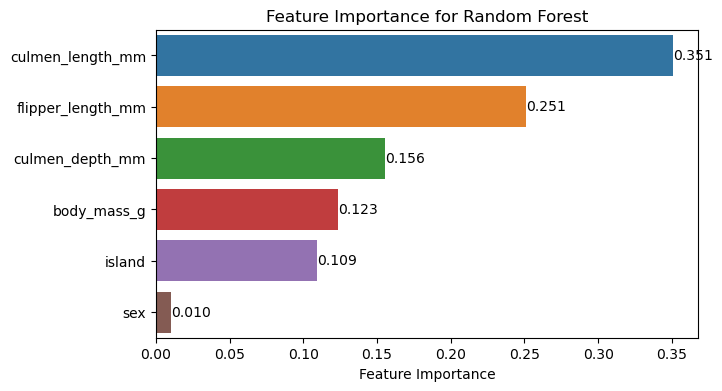

In [36]:
ax = sns.barplot(x=rf_feature_imp["Feature Importance"], y=rf_feature_imp.index)
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.title("Feature Importance for Random Forest")
plt.show()

# Görselleştiriyoruz.

## Understanding Hyperparameters

In [37]:
from sklearn.tree import plot_tree 

def report_model(model, number_of_tree):
    model_pred = model.predict(X_test)
    model_train_pred = model.predict(X_train)
    print('\n')
    print("Test Set")
    print(confusion_matrix(y_test, model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))
    print('\n')
    print("Train Set")
    print(confusion_matrix(y_train, model_train_pred))
    print('\n')
    print(classification_report(y_train,model_train_pred))
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model["RF_model"].estimators_[number_of_tree], feature_names=new_features, #features_names=X.columns
          class_names=df.species.unique(),
          filled = True,
          fontsize = 8);

# model["RF_model"].estimators_[number_of_tree] kodu ile agaç numarasını (number_of_tree) vererek istediğimiz agacı
# görselleştirebiliyoruz.

In [60]:
RF_model = RandomForestClassifier(random_state=101, max_samples=0.5)
operations = [("OrdinalEncoder", column_trans), ("RF_model", RF_model)]

pruned_tree = Pipeline(steps=operations) # pruned_tree = RandomForestClassifier(max_samples=0.5)

pruned_tree.fit(X_train,y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('RF_model',
                 RandomForestClassifier(max_samples=0.5, random_state=101))])



Test Set
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]


              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



Train Set
[[117   0   0]
 [  1  53   0]
 [  0   0  95]]


              precision    recall  f1-score   support

      Adelie       0.99      1.00      1.00       117
   Chinstrap       1.00      0.98      0.99        54
      Gentoo       1.00      1.00      1.00        95

    accuracy                           1.00       266
   macro avg       1.00      0.99      1.00       266
weighted avg       1.00      1.00      1.00       266



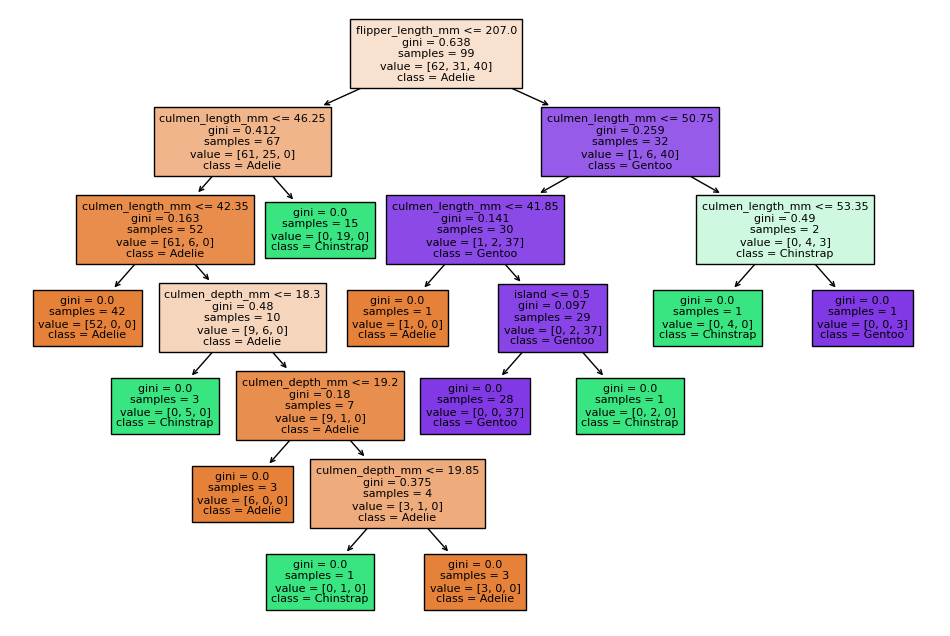

In [72]:
report_model(pruned_tree, 25)

# 133*2/3 = 89

# train darasında bulunan 266 gözlemin yarısının(max_samples=0.5 old. için) yaklaşık olarak 2/3'ü her agaçta kullanılıyor. bu agaçta gördüğünüz gibi bu orana yakın 
# bir gözlem kullanılmıştır.

## Final Model and Prediction

In [73]:
X = df.drop(columns=["species"])
y = df['species']

In [74]:
X.head(2)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE


In [75]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline


operations = [("transformer", column_trans), ("RF", RandomForestClassifier(random_state=101))]
pipe_model = Pipeline(steps=operations)
pipe_model.fit(X, y)

# scorlarımız çok iyi olduğundan gridsearch yapmadık aşağıda çözeceğimiz diabet datasetinde gridsearch yapacağız.

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('RF', RandomForestClassifier(random_state=101))])

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
culmen_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0


In [77]:
observations = {"island": ["Torgersen", "Biscoe"], "culmen_length_mm":[39, 48], "culmen_depth_mm":[18, 14],
               "flipper_length_mm":[180, 213], "body_mass_g":[3700, 4800], "sex":["MALE", "FEMALE"]}

obs = pd.DataFrame(observations)
obs

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39,18,180,3700,MALE
1,Biscoe,48,14,213,4800,FEMALE


In [78]:
pipe_model.predict(obs)

array(['Adelie', 'Gentoo'], dtype=object)

# DT and RF Scoring for diabetes dataset

In [79]:
df = pd.read_csv("diabetes.csv")

In [80]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning Outliers

In [81]:
df=df[df.SkinThickness<70]
df=df[df.Glucose>0]
df=df[df.BloodPressure>35]
df=df[df.BMI>0]

# outlierlardan hızlı pratik bir şekilde temizliyoruz.

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               720 non-null    int64  
 1   Glucose                   720 non-null    int64  
 2   BloodPressure             720 non-null    int64  
 3   SkinThickness             720 non-null    int64  
 4   Insulin                   720 non-null    int64  
 5   BMI                       720 non-null    float64
 6   DiabetesPedigreeFunction  720 non-null    float64
 7   Age                       720 non-null    int64  
 8   Outcome                   720 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.2 KB


In [83]:
df.Outcome.value_counts()

0    473
1    247
Name: Outcome, dtype: int64

## Train | Test Split and Scalling

In [84]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Modelling and Model Performance

### Decision Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)
dt_model.fit(X_train, y_train)
eval_metric(dt_model, X_train, y_train, X_test, y_test)

# datamız dengesiz olduğundan ve hedef labelımın skoru kötü olduğundan direk class_weight = "balanced" kullandım. Dengesiz
# data setlerinde class_weight'i gridsearche vermeye gerek yok.

Test_Set
[[75 20]
 [23 26]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        95
           1       0.57      0.53      0.55        49

    accuracy                           0.70       144
   macro avg       0.67      0.66      0.66       144
weighted avg       0.70      0.70      0.70       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [88]:
from sklearn.model_selection import StratifiedKFold

model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)


cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# overfitingi teyit ediyorum.

test_accuracy      0.711766
train_accuracy     1.000000
test_precision     0.589251
train_precision    1.000000
test_recall        0.551316
train_recall       1.000000
test_f1            0.565202
train_f1           1.000000
dtype: float64

In [89]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 2, 3],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3,4,5]}

In [90]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=101)

cv = StratifiedKFold(n_splits=10)
dt_grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='recall',
                            cv = cv,
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


In [91]:
dt_grid_model.best_params_

{'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'random'}

In [92]:
dt_grid_model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       random_state=101, splitter='random')

In [93]:
eval_metric(dt_grid_model, X_train, y_train, X_test, y_test)

# overfiting yok görünüyor ama kesin teyidimizi CV'da yapacağız.

# Hedef classımız Test datasındaki 1 scorlarını  CV'dan alacağımız validation setlerinin ortalama değeri ile karşılaştırıp 
# skorumuzu teyit edeceğiz.

Test_Set
[[33 62]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.87      0.35      0.50        95
           1       0.42      0.90      0.57        49

    accuracy                           0.53       144
   macro avg       0.64      0.62      0.53       144
weighted avg       0.71      0.53      0.52       144


Train_Set
[[133 245]
 [  8 190]]
              precision    recall  f1-score   support

           0       0.94      0.35      0.51       378
           1       0.44      0.96      0.60       198

    accuracy                           0.56       576
   macro avg       0.69      0.66      0.56       576
weighted avg       0.77      0.56      0.54       576



In [94]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       random_state=101, splitter='random')

cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# Overfiting yok. Test datasındaki 1 classının skorları ile validation setinin skorları tutarlı.

test_accuracy      0.559074
train_accuracy     0.563274
test_precision     0.437143
train_precision    0.438265
test_recall        0.959474
train_recall       0.959595
test_f1            0.600060
train_f1           0.601704
dtype: float64

In [95]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve,\
                            average_precision_score

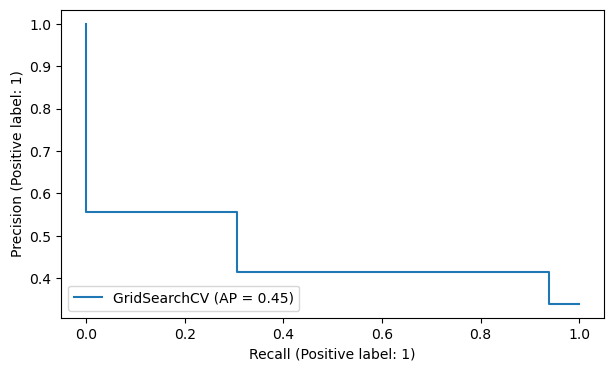

In [96]:
plot_precision_recall_curve(dt_grid_model, X_test, y_test);

# modelin genel performansı çok düşük.

### Random Forest

In [97]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_model.fit(X_train, y_train)

# datamız dengesiz olduğundan ve hedef labelımın skoru kötü olduğundan direk class_weight = "balanced" kullandım. Dengesiz
# data setlerinde class_weight'i gridsearche vermeye gerek yok.

RandomForestClassifier(class_weight='balanced', random_state=101)

In [98]:
eval_metric(rf_model, X_train, y_train, X_test, y_test)

# overfiting var görünüyor.

Test_Set
[[83 12]
 [24 25]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        95
           1       0.68      0.51      0.58        49

    accuracy                           0.75       144
   macro avg       0.73      0.69      0.70       144
weighted avg       0.74      0.75      0.74       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [99]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)

cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv,
                       return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# overfiting olduğunu teyit ettim.

test_accuracy      0.763944
train_accuracy     1.000000
test_precision     0.702761
train_precision    1.000000
test_recall        0.570000
train_recall       1.000000
test_f1            0.616765
train_f1           1.000000
dtype: float64

## GridSearch

In [100]:
param_grid = {'n_estimators':[64, 128, 200],
             'max_features':[2, 4, 'sqrt'],
             'max_depth':[2, 3, 4],
             'min_samples_split':[2, 3,4],
             'min_samples_leaf': [2,3,4],
             'max_samples':[0.8, 1]} # add 1

In [101]:
model = RandomForestClassifier(class_weight={0:1, 1:4},random_state=101)
rf_grid_model = GridSearchCV(model, param_grid, scoring = "recall", n_jobs = -1, verbose=2).fit(X_train, y_train)

# class_weight="balanced" yetersiz geldiğinden 1'e 4 oranında ağırlıklandırıldı.

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [102]:
rf_grid_model.best_params_

{'max_depth': 2,
 'max_features': 2,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 64}

In [103]:
rf_grid_model.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.8, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

In [104]:
rf_grid_model.best_score_

0.9597435897435898

In [105]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

# overfiting giderilmiş görünüyor ama kesin teyidimizi CV'da yapacağız.

# Hedef classımız Test datasındaki 1 scorlarını  CV'dan alacağımız validation setlerinin ortalama değeri ile karşılaştırıp 
# skorumuzu teyit edeceğiz.

Test_Set
[[45 50]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62        95
           1       0.47      0.90      0.62        49

    accuracy                           0.62       144
   macro avg       0.68      0.69      0.62       144
weighted avg       0.75      0.62      0.62       144


Train_Set
[[154 224]
 [  3 195]]
              precision    recall  f1-score   support

           0       0.98      0.41      0.58       378
           1       0.47      0.98      0.63       198

    accuracy                           0.61       576
   macro avg       0.72      0.70      0.60       576
weighted avg       0.80      0.61      0.60       576



In [127]:
model = RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.8, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

cv = StratifiedKFold(n_splits=10)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# Overfiting olmadığını teyit ettim. Test datasındaki 1 classının skorları ile validation setinin skorları tutarlı.

test_accuracy      0.604144
train_accuracy     0.614193
test_precision     0.464524
train_precision    0.470670
test_recall        0.965000
train_recall       0.979242
test_f1            0.626629
train_f1           0.635736
dtype: float64

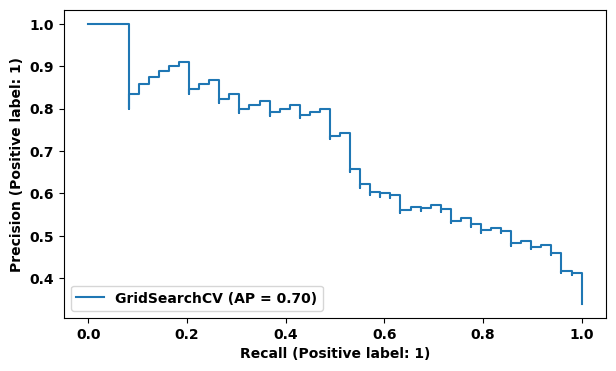

In [128]:
plot_precision_recall_curve(rf_grid_model, X_test, y_test);

# RF modelin genel performancı DT'den çok daha iyi